In [1]:
import sys
sys.path.insert(0, '../py')
from graviti import *

In [2]:
import numpy as np
import scipy as sp
from scipy.sparse import coo_matrix
import scipy.ndimage as ndi

from skimage.draw import polygon
from skimage import io
from skimage.measure import label, regionprops
import skimage.io
import skimage.measure
import skimage.color

import glob
import pandas as pd
import os
import timeit

import pyvips

In [3]:
from __future__ import print_function

import histomicstk as htk

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [4]:
def make_mask_from_polygons(filename,x_list,y_list):
    if not (x_list and y_list):
        pass
    else:
        xx = np.array(x_list).reshape((len(x_list),1))
        yy = np.array(y_list).reshape((len(y_list),1))

        arr = np.hstack((xx,yy))

        # subtract the min to translate the mask                                                                                                                                                                   
        mini = np.min(arr,axis=0); arr -= mini

        rr = np.rint(arr[:,1]).astype(int) # xs are cols                                                                                                                                                           
        cc = np.rint(arr[:,0]).astype(int) # ys are rows                                                                                                                                                           
        mtx = coo_matrix((np.ones(rr.shape), (rr, cc)), dtype=bool)
        
        #plt.figure(figsize=(40,40))
        #io.imshow(mtx.todense(),cmap='gray')
        #plt.savefig(filename+'.png')
    return mtx.todense()

In [5]:
def get_nuclear_view(imInput,maska,z):
    masked = np.multiply(imInput[:,:,z],maska)
    norows = masked[~np.all(masked == 0, axis=1)] #remove 0 rows
    arr = norows[:,~(norows == 0).all(0)] # remove 0 cols
    return arr 

In [6]:
# get the features 
# consider as features x,y,r,g,b,delta_x([r,g,b])+delta_y([r,g,b]),delta_xx([r,g,b])+delta_yy([r,g,b])
def features_from_3d(arr_3d,color_dim): # color_dim is 0,1,2 for R,G,B
    dx = np.array([[0.0,0,0.0],[-1.0,0,1.0],[0.0,0,0.0],])
    dy = np.transpose(dx)
    dxx = np.array([[0.0,0,0.0],[-1.0,2.0,-1.0],[0.0,0,0.0],])
    dyy = np.transpose(dxx)

    arr_2d = arr_3d[:,:,color_dim]
    coo = coo_matrix(arr_2d)
    
    row = coo.row
    col = coo.col
        
    delta_x = ndi.convolve(arr_2d,dx, output=np.float64, mode='nearest')
    delta_y = ndi.convolve(arr_2d,dy, output=np.float64, mode='nearest')
        
    delta_xx = ndi.convolve(arr_2d,dxx, output=np.float64, mode='nearest')
    delta_yy = ndi.convolve(arr_2d,dyy, output=np.float64, mode='nearest')
    
    return delta_x, delta_y, delta_xx, delta_yy

In [7]:
def parse_polygons_in_patch(filename):
    x_list = []
    y_list = []
    df = pd.read_csv(filename)
    if ~df.empty:
        cell_list = df['Polygon'].tolist()
        for cell in cell_list: # loop over cells in patch                                                                                                                                                          
            lista = list(np.fromstring(cell[1:-1], dtype=float, sep=':')) #list of vertices in polygon                                                                                                             
            cc = lista[0::2] # list of x coord of each polygon vertex                                                                                                                                              
            rr = lista[1::2] # list of y coord of each polygon verted                                                                                                                                              
            poly = np.asarray(list(zip(rr,cc)))
            mini = np.min(poly,axis=0)
            poly -= mini # subtract the min to translate the mask                                                                                                                                                  

            # create the nuclear mask                                                                                                                                                                              
            mask = np.zeros(tuple(np.ceil(np.max(poly,axis=0) - np.min(poly,axis=0)).astype(int)))
            rr, cc = polygon(poly[:, 0], poly[:, 1], mask.shape) # get the nonzero mask locations                                                                                                                  
            mask[rr, cc] = 1 # nonzero pixel entries                                                                                                                                                               
            # rescale back to original coordinates                                                                                                                                                                 
            rr = rr.astype(float);cc = cc.astype(float)
            rr += mini[0]; cc += mini[1]

            # update the list of nonzero pixel entries                                                                                                                                                             
            x_list.extend( [int(n) for n in list(cc)] )
            y_list.extend( [int(n) for n in list(rr)] )
        mask = make_mask_from_polygons(filename,x_list,y_list)
    return mask

In [8]:
def tile_from_svs(svs_filename,mask,x,y):
    
    format_to_dtype = {
    'uchar': np.uint8,
    'char': np.int8,
    'ushort': np.uint16,
    'short': np.int16,
    'uint': np.uint32,
    'int': np.int32,
    'float': np.float32,
    'double': np.float64,
    'complex': np.complex64,
    'dpcomplex': np.complex128,
    }
    
    image = pyvips.Image.new_from_file(svs_filename)[0:3] # drop alpha channel
    tile = image.crop(x,y,mask.shape[1],mask.shape[0])
    np_3d = np.ndarray(buffer=tile.write_to_memory(),
                       dtype=format_to_dtype[tile.format],
                       shape=[tile.height, tile.width, tile.bands])
    
    #print(tile.height, tile.width, tile.bands, tile.format, tile.interpretation)
    #tile.write_to_file(svs_filename+'.'+str(x)+'.'+str(y)+'.jpg[Q=100]') # save as jpg file
    return np_3d

In [75]:
patches = glob.glob('/home/garner1/pipelines/nucleAI/data/TCGA-05-4244-*.*.svs.tar.gz/luad_polygon/*/*.csv')

In [77]:
# Load the mask
svs_filename = "/home/garner1/pipelines/nucleAI/data/TCGA-05-4244-01Z-00-DX1.d4ff32cd-38cf-40ea-8213-45c2b100ac01.svs"

for patch in patches[:3]:
    patch_name = patch.split('/')[9:]
    if not pd.read_csv(patch).empty: 
        print('The patch is not empty',patch_name[0])
        x = patch_name[0].split('_')[0]
        y = patch_name[0].split('_')[1]
        #print(x,y)
        imInput = tile_from_svs(svs_filename,mask,x,y)
        #plt.imshow(imInput)
        mask = parse_polygons_in_patch(patch)
        
        labels, num = label(mask, return_num=True, connectivity=1) # connectivity has to be 1 otherwise different mask are placed together

        for l in range(num+1)[1:2]: # for every nucleus, label id start from 1
            print(l)
            maska = labels == l # get the mask
            if maska.nonzero()[0].shape[0] > 100: # condition on mask size
                # Repeat over the third axis of the image
                arr0 = get_nuclear_view(imInput,maska,0)
                arr1 = get_nuclear_view(imInput,maska,1)
                arr2 = get_nuclear_view(imInput,maska,2)

                arr_3d = np.dstack((arr0,arr1,arr2))
                
                #plt.figure()
                #plt.imshow(arr_3d)
                #plt.savefig('./nucleus_'+str(l)+'.png')
                
                # get the features
                delta_x_R, delta_y_R, delta_xx_R, delta_yy_R = features_from_3d(arr_3d,0)
                delta_x_G, delta_y_G, delta_xx_G, delta_yy_G = features_from_3d(arr_3d,1)
                delta_x_B, delta_y_B, delta_xx_B, delta_yy_B = features_from_3d(arr_3d,2)

                delta_x = np.zeros((arr_3d.shape[0],arr_3d.shape[1]))
                delta_xx = np.zeros((arr_3d.shape[0],arr_3d.shape[1]))
                delta_y = np.zeros((arr_3d.shape[0],arr_3d.shape[1]))
                delta_yy = np.zeros((arr_3d.shape[0],arr_3d.shape[1]))
                for r in range(arr_3d.shape[0]):
                    for c in range(arr_3d.shape[1]):
                        delta_x[r,c] = np.sqrt(delta_x_R[r,c]**2+delta_x_G[r,c]**2+delta_x_B[r,c]**2)
                        delta_xx[r,c] = np.sqrt(delta_xx_R[r,c]**2+delta_xx_G[r,c]**2+delta_xx_B[r,c]**2)
                        delta_y[r,c] = np.sqrt(delta_y_R[r,c]**2+delta_y_G[r,c]**2+delta_y_B[r,c]**2)
                        delta_yy[r,c] = np.sqrt(delta_yy_R[r,c]**2+delta_yy_G[r,c]**2+delta_yy_B[r,c]**2)

                feature_data = np.zeros((arr_3d.shape[0]*arr_3d.shape[1],9))
                idx = 0
                for r in range(arr_3d.shape[0]):
                    for c in range(arr_3d.shape[1]):
                        feature_data[idx,:] = np.hstack((r,c,
                                                    arr_3d[r,c,0],arr_3d[r,c,1],arr_3d[r,c,2],
                                                    delta_x[r,c],delta_y[r,c],
                                                    delta_xx[r,c],delta_yy[r,c]))
                        idx += 1
                #print(np.corrcoef(feature_data,rowvar=False)) # get the normalized covariace matrix
    else:
        print('The patch is empty')

The patch is empty
The patch is not empty 8001_16001_4000_4000_0.2325_1-features.csv
1
The patch is not empty 20001_16001_4000_4000_0.2325_1-features.csv
1


In [59]:
feature_data = np.zeros((arr_3d.shape[0]*arr_3d.shape[1],9))
idx = 0
for r in range(arr_3d.shape[0]):
    for c in range(arr_3d.shape[1]):
        feature_data[idx,:] = np.hstack((r,c,
                                    arr_3d[r,c,0],arr_3d[r,c,1],arr_3d[r,c,2],
                                    delta_x[r,c],delta_y[r,c],
                                    delta_xx[r,c],delta_yy[r,c]))
        idx += 1

print(np.corrcoef(feature_data,rowvar=False)) # get the normalized covariace matrix
print(np.cov(feature_data,rowvar=False)) # get the covariace matrix

[[ 1.          0.         -0.3586786  -0.32493749 -0.42973312 -0.12668989
   0.01018039 -0.0574167  -0.00791796]
 [ 0.          1.         -0.28066858 -0.28827957 -0.22742128  0.00600567
  -0.0108636   0.00328291  0.03869368]
 [-0.3586786  -0.28066858  1.          0.98932974  0.96825636  0.08430803
   0.02971244  0.02421819  0.01813399]
 [-0.32493749 -0.28827957  0.98932974  1.          0.9714328   0.08721738
   0.03520539  0.02913573  0.02163109]
 [-0.42973312 -0.22742128  0.96825636  0.9714328   1.          0.08847009
   0.02719926  0.01925345  0.02505057]
 [-0.12668989  0.00600567  0.08430803  0.08721738  0.08847009  1.
   0.487511    0.97035504  0.49064709]
 [ 0.01018039 -0.0108636   0.02971244  0.03520539  0.02719926  0.487511
   1.          0.49535396  0.95967956]
 [-0.0574167   0.00328291  0.02421819  0.02913573  0.01925345  0.97035504
   0.49535396  1.          0.49589018]
 [-0.00791796  0.03869368  0.01813399  0.02163109  0.02505057  0.49064709
   0.95967956  0.49589018  1.   

stain_color_map:
{'hematoxylin': [0.65, 0.7, 0.29], 'eosin': [0.07, 0.99, 0.11], 'dab': [0.27, 0.57, 0.78], 'null': [0.0, 0.0, 0.0]}


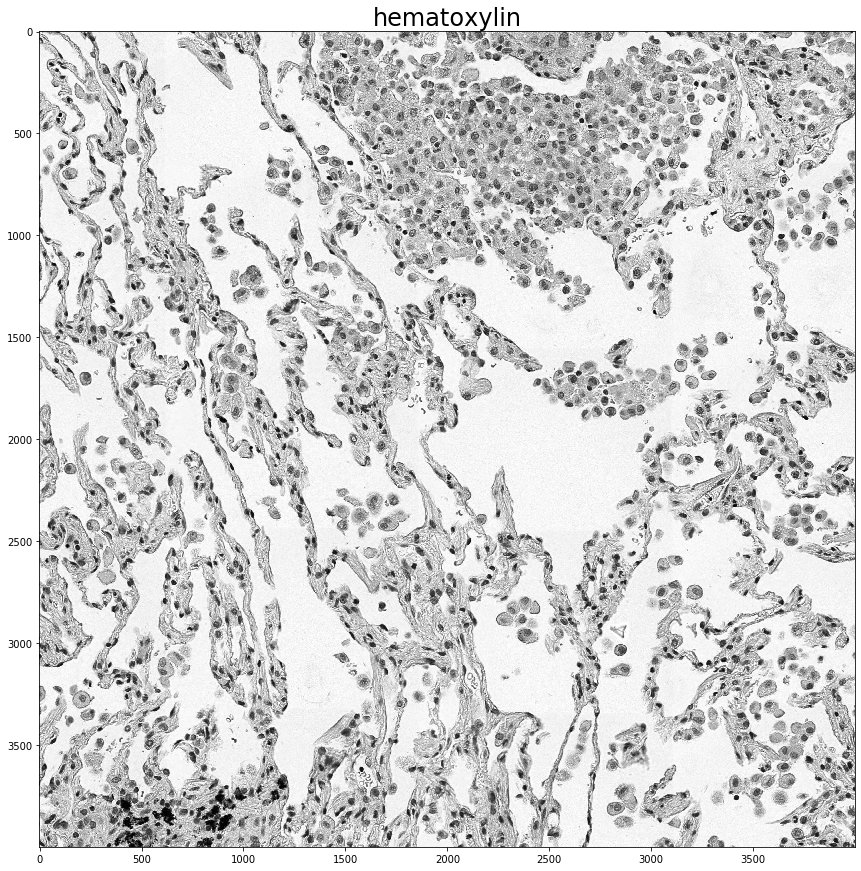

In [10]:
# create stain to color map
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

# create stain matrix
W = np.array([stain_color_map[st] for st in stains]).T

# perform standard color deconvolution
imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, W)

# Display results
for i in [0]:#, 1:
    plt.figure()
    plt.imshow(imDeconvolved.Stains[:, :, i])
    _ = plt.title(stains[i], fontsize=titlesize)

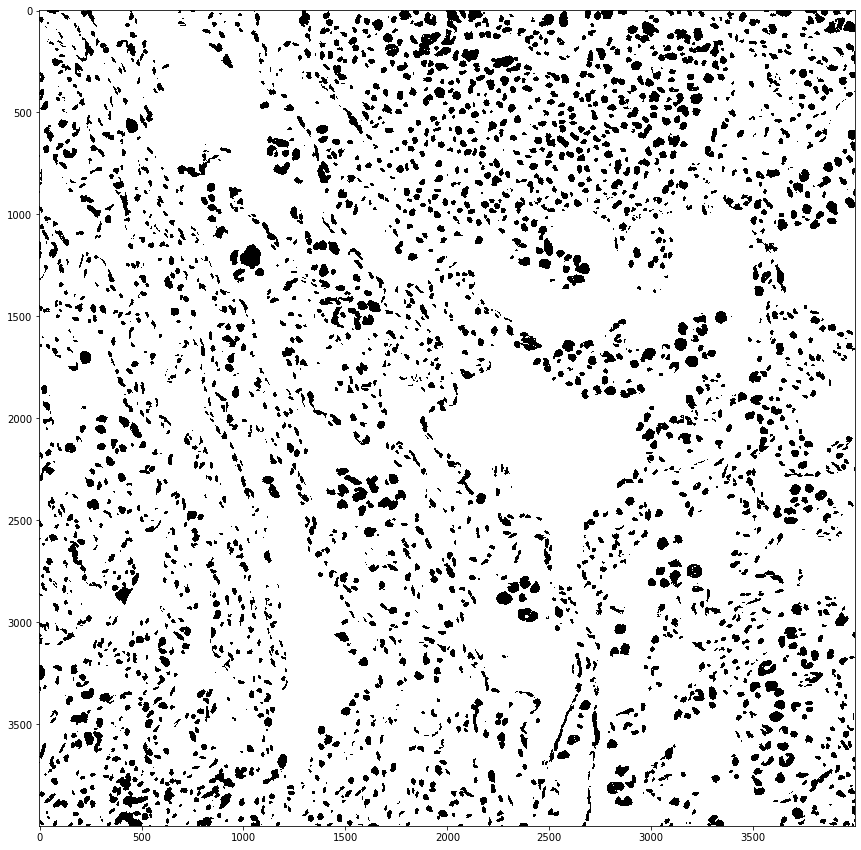

In [11]:
plt.figure()
masked = np.multiply(imDeconvolved.Stains[:, :, 0],~mask)
plt.imshow(masked>1)